# Initial setup

In [1]:
import imdb_code as imdb
import imdb_helper_functions as ihf
import pandas as pd
import math
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# checking cache (loads with imdb_helper_functions import)
len(ihf.actor_by_url), len(ihf.movie_by_url),len(ihf.parsed_actors), len(ihf.parsed_movies)

(161989, 38185, 2754, 6326)

## Initial actors URLs dictionary

In [3]:
url_by_actor = {
'Dwayne Johnson': 'https://www.imdb.com/name/nm0425005/',
'Robert Downey Jr.': 'imdb.com/name/nm0000375/',
'Chris Hemsworth': 'www.imdb.com/name/nm1165110/',
'Akshay Kumar': 'imdb.com/name/nm0474774/',
'Jackie Chan': 'imdb.com/name/nm0000329/',
'Bradley Cooper': 'imdb.com/name/nm0177896/',
'Adam Sandler': 'imdb.com/name/nm0001191/',
'Scarlett Johansson': 'https://www.imdb.com/name/nm0424060/',
'Sofia Vergara': 'imdb.com/name/nm0005527/',
'Chris Evans': 'imdb.com/name/nm0262635/',
}
#preprocessing url
for name, link in url_by_actor.items():
    url = ihf.complete_url(link, opt='credits')
    url_by_actor[name] = url
    ihf.actor_by_url[url] = name


## Constants

In [4]:
num_of_actors_limit = 5
num_of_movies_limit = 5
distance_limit = 3

## Selenium Driver setup

In [5]:
ihf.driver = ihf.driver_setup()

# Start Working

### Dictionary of distances

In [6]:
distances = {url: 
                {urrl: math.inf if url != urrl else 0 
                        for urrl in url_by_actor.values()} 
            for url in url_by_actor.values()}
#distances

### Calculating distances

In [7]:
for start in distances:
    for end in distances:
        distances[start][end] = imdb.get_movie_distance(start, end, 
                                                    num_of_actors_limit, 
                                                    num_of_movies_limit,
                                                    distance_limit)
    

D1: Checking Dwayne Johnson: https://www.imdb.com/name/nm0425005/fullcredits/
Number of costars: 21
D2: Checking Utkarsh Ambudkar: https://www.imdb.com/name/nm2064295/fullcredits/
Number of costars: 22
D2: Checking Joe Keery: https://www.imdb.com/name/nm6564737/fullcredits/
Number of costars: 21
D2: Checking Lil Rel Howery: https://www.imdb.com/name/nm2577076/fullcredits/
Number of costars: 21
D2: Checking Jodie Comer: https://www.imdb.com/name/nm3069650/fullcredits/
Number of costars: 16
D2: Checking Chris Diamantopoulos: https://www.imdb.com/name/nm0224565/fullcredits/
Number of costars: 21
D2: Checking Ritu Arya: https://www.imdb.com/name/nm5709125/fullcredits/
Number of costars: 23
D2: Checking Gal Gadot: https://www.imdb.com/name/nm2933757/fullcredits/
Number of costars: 24
D2: Checking Ryan Reynolds: https://www.imdb.com/name/nm0005351/fullcredits/
Number of costars: 22
D2: Checking Vanessa Bayer: https://www.imdb.com/name/nm3364779/fullcredits/
Number of costars: 22
D2: Checking

### Creating DataFrame of distances and saving it to file

In [8]:
# If there is no connection between actors set distance equal to -1
actor_distances = {ihf.actor_by_url[actor]: 
            {ihf.actor_by_url[url]: int(value) if value != math.inf else -1
            for url, value in urls.items() } 
        for actor, urls in distances.items()}

dist_df = pd.DataFrame(actor_distances)#.fillna(-1).astype(int)
dist_df.to_csv('distances.csv')
dist_df

Dwayne Johnson  Robert Downey Jr.  Chris Hemsworth  \
Dwayne Johnson                   0                  2                3   
Robert Downey Jr.                3                  0                2   
Chris Hemsworth                  2                  1                0   
Akshay Kumar                    -1                 -1                3   
Jackie Chan                      3                  3                2   
Bradley Cooper                   2                  3                3   
Adam Sandler                     3                  3               -1   
Scarlett Johansson               3                  1                2   
Sofia Vergara                    3                  3               -1   
Chris Evans                      2                  1                2   

                    Akshay Kumar  Jackie Chan  Bradley Cooper  Adam Sandler  \
Dwayne Johnson                -1            3               2             3   
Robert Downey Jr.             -1           -1               3             3   
Chris Hemsworth                3            3               2             3   
Akshay Kumar                   0           -1              -1            -1   
Jackie Chan                    3            0              -1             3   
Bradley Cooper                -1            3               0             2   
Adam Sandler                  -1            3               2             0   
Scarlett Johansson            -1            3               2             3   
Sofia Vergara                 -1           -1               2             2   
Chris Evans                   -1            3               2             3   

                    Scarlett Johansson  Sofia Vergara  Chris Evans  
Dwayne Johnson                       3              3            2  
Robert Downey Jr.                    2              3            2  
Chris Hemsworth                      2              3            2  
Akshay Kumar                        -1             -1           -1  
Jackie Chan                         -1             -1           -1  
Bradley Cooper                       3              3            3  
Adam Sandler                         3              2            3  
Scarlett Johansson                   0              2            2  
Sofia Vergara                        3              0            3  
Chris Evans                          2              3            0

# Graphs

In [9]:
# values of distances
dist_values = dist_df.values.reshape(1,-1)
dist_values = set(dist_values.tolist()[0])
dist_values.difference_update({-1, 0})
dist_values

{1, 2, 3}

## Directed Graph
Let $d(A, B)$ be distance between actors A and B.

Taking into account limitations on number of movies and actors we work with,
 $d(A, B)$ might not be equal to $d(B, A)$

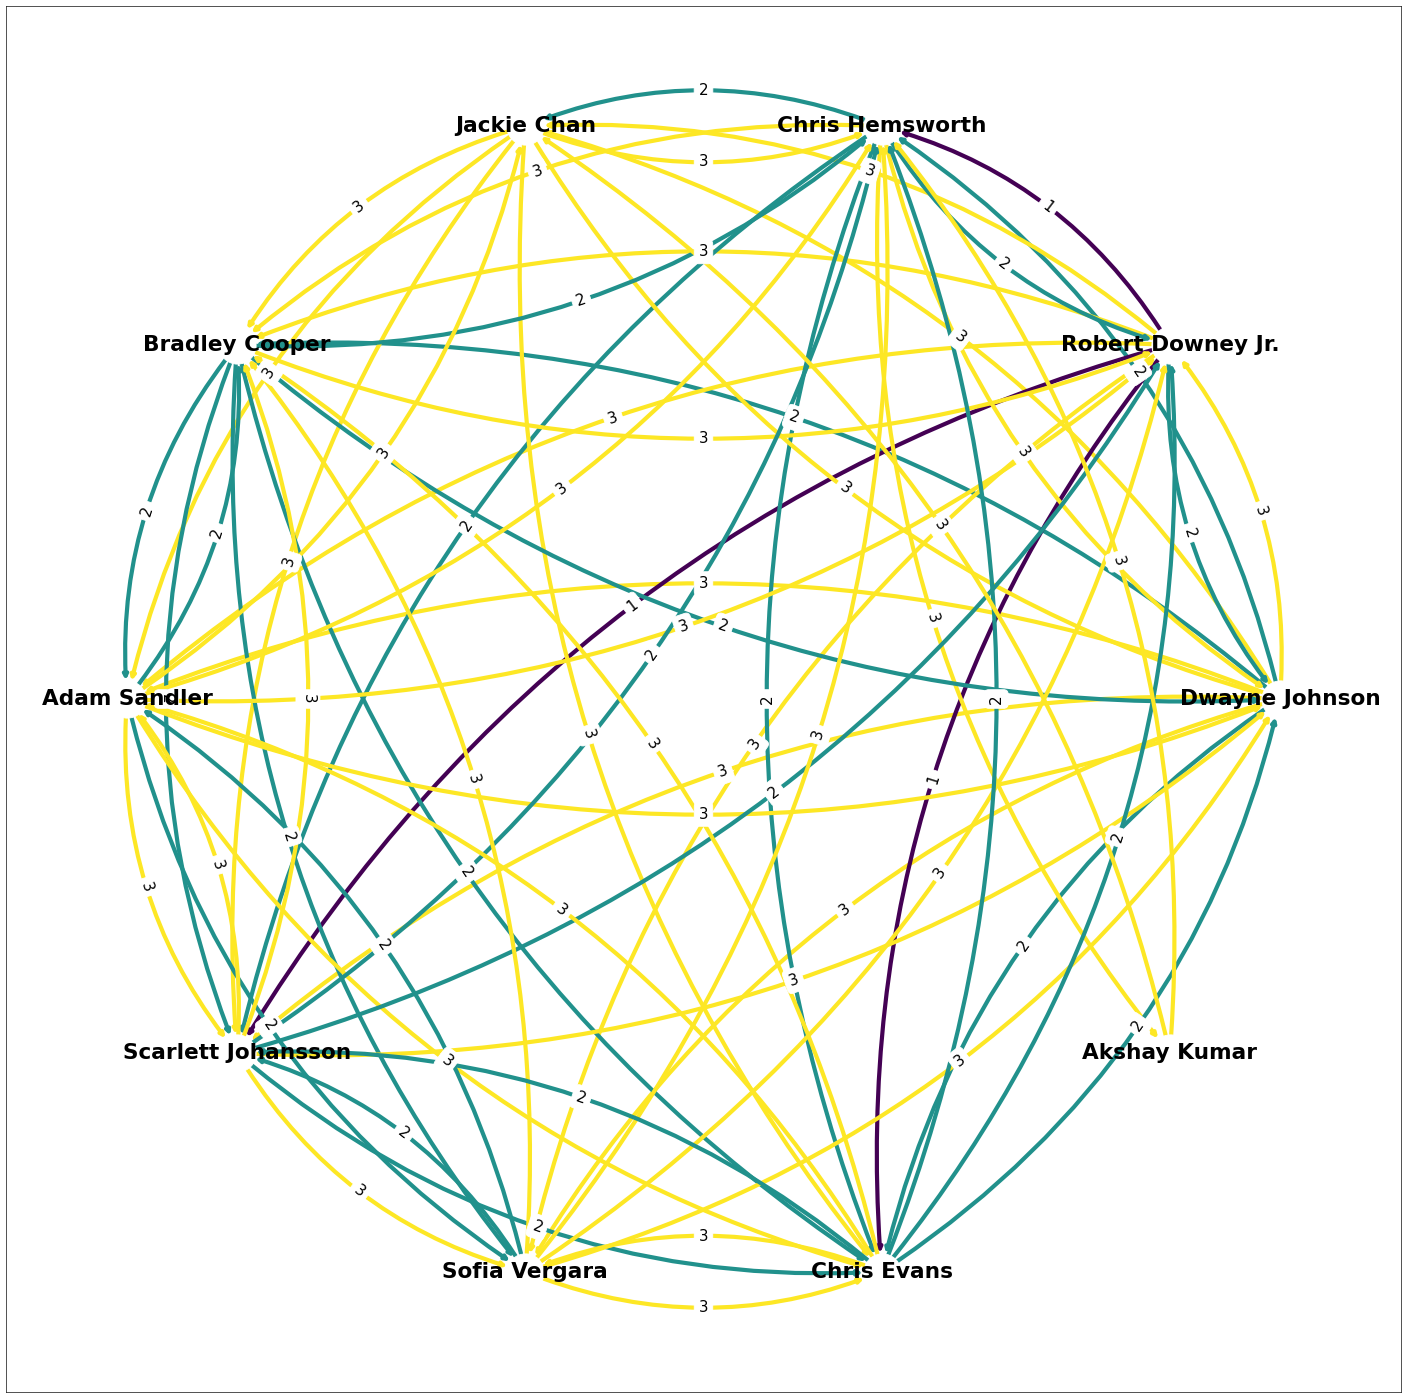

In [10]:
graph = nx.DiGraph()
for actor1 in actor_distances:
    for actor2 in actor_distances:
        w = actor_distances[actor1][actor2]
        if w > 0:
            graph.add_edge(actor1, actor2, weight=w)

fig = plt.figure(figsize=(30, 30), dpi=60)
pos = nx.layout.circular_layout(graph)

edge_weights = nx.get_edge_attributes(graph, "weight")
edges, lengths = zip(*edge_weights.items())

nx.draw_networkx(graph, pos, node_color="white", edgelist=edges, node_size=2000,
                 edge_color=lengths, width=5, font_size=26, font_weight='bold',
                 connectionstyle='arc3,rad=0.2',arrows=True)

nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_weights, 
                             font_size=18,
                             connectionstyle='arc3,rad=0.2')
plt.show()

### Graphs by distance

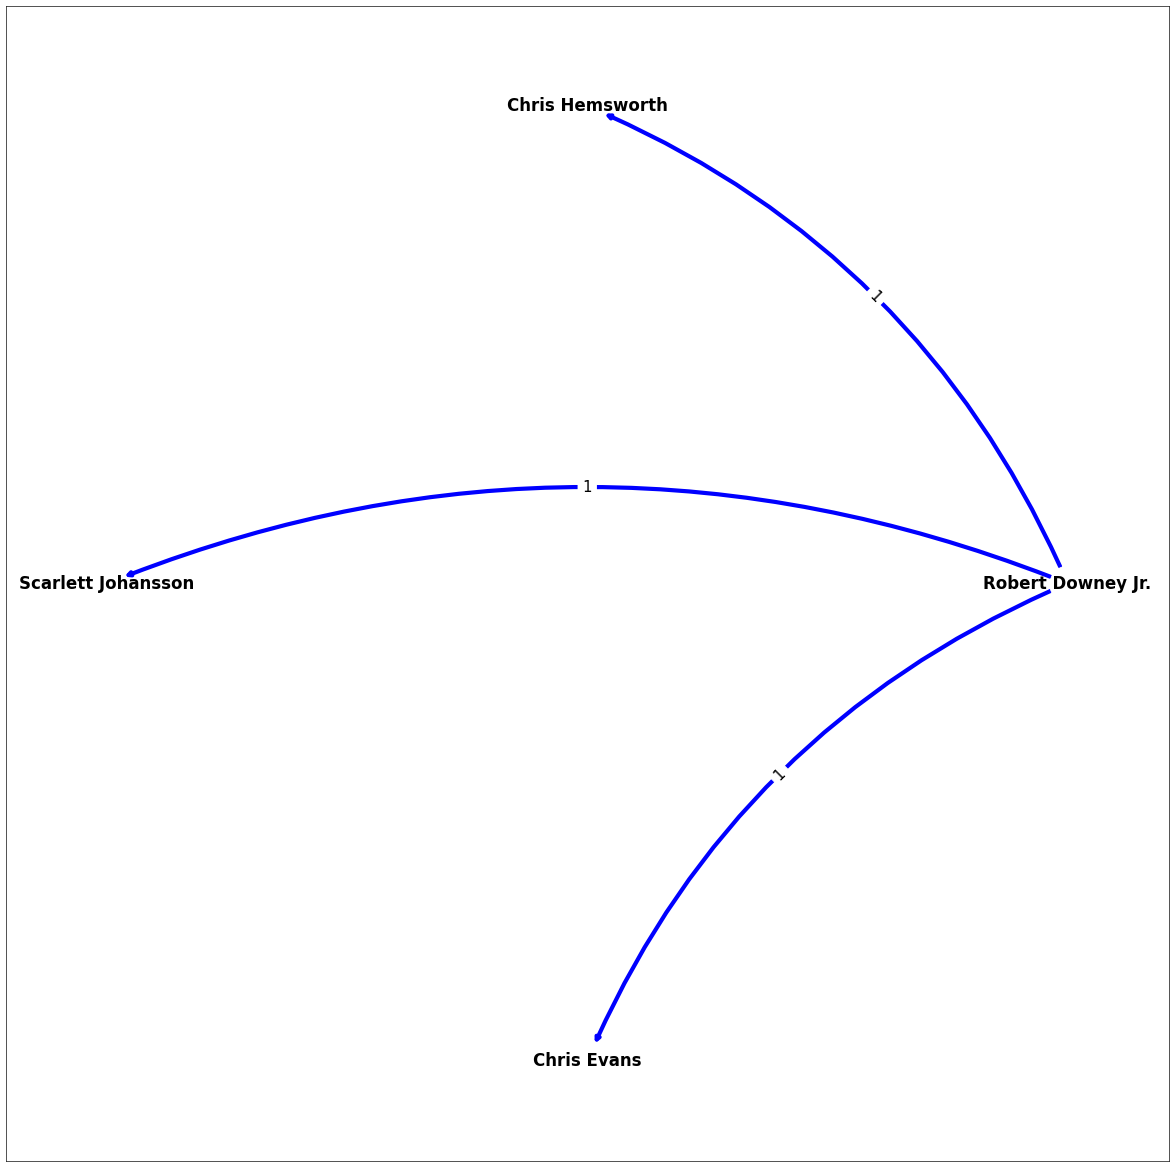

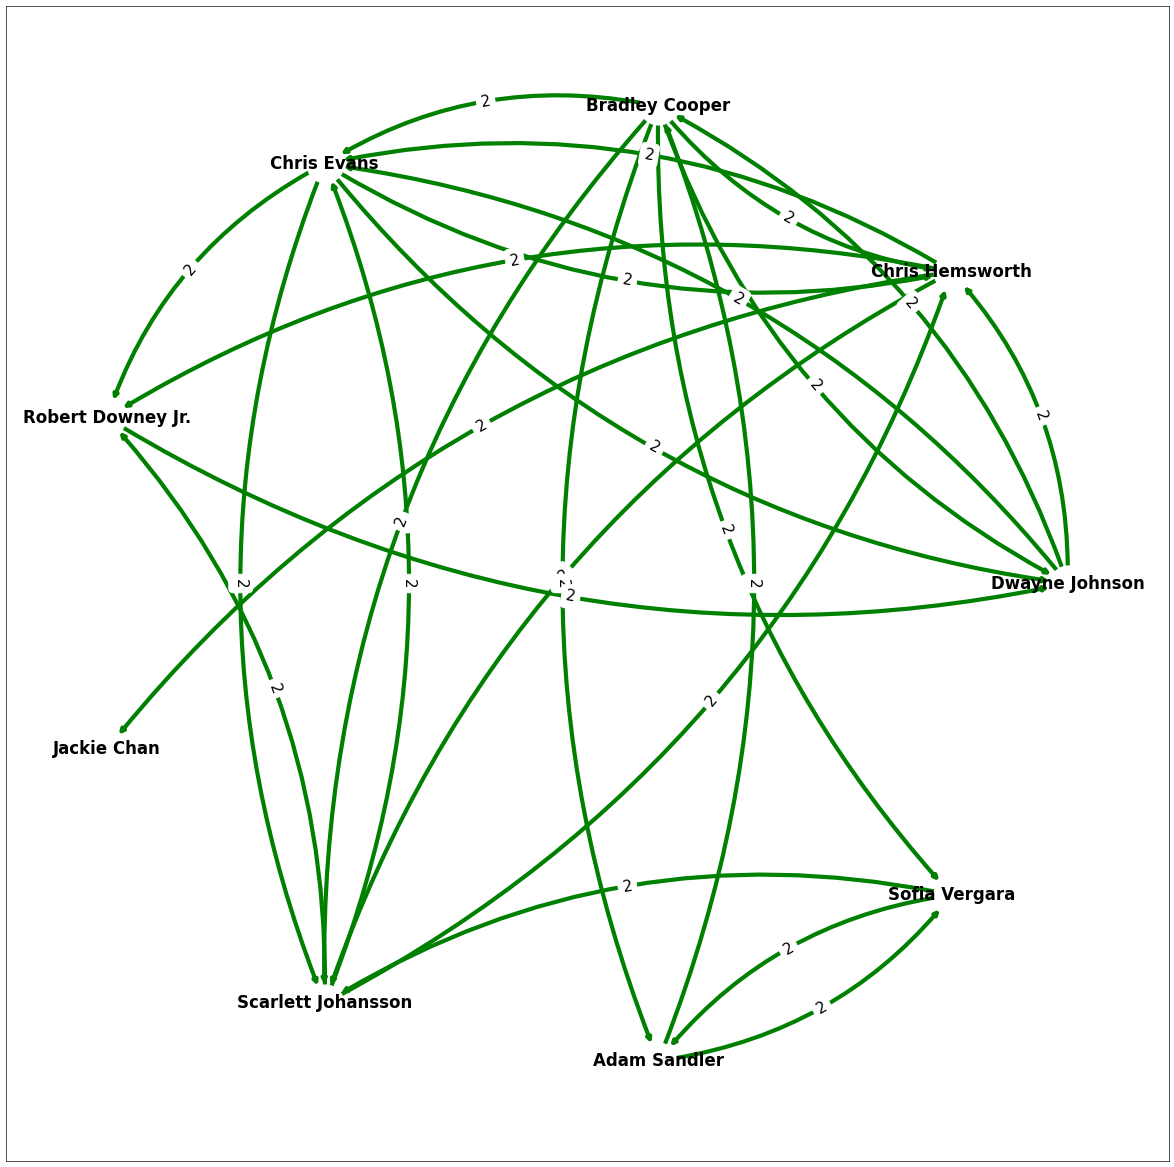

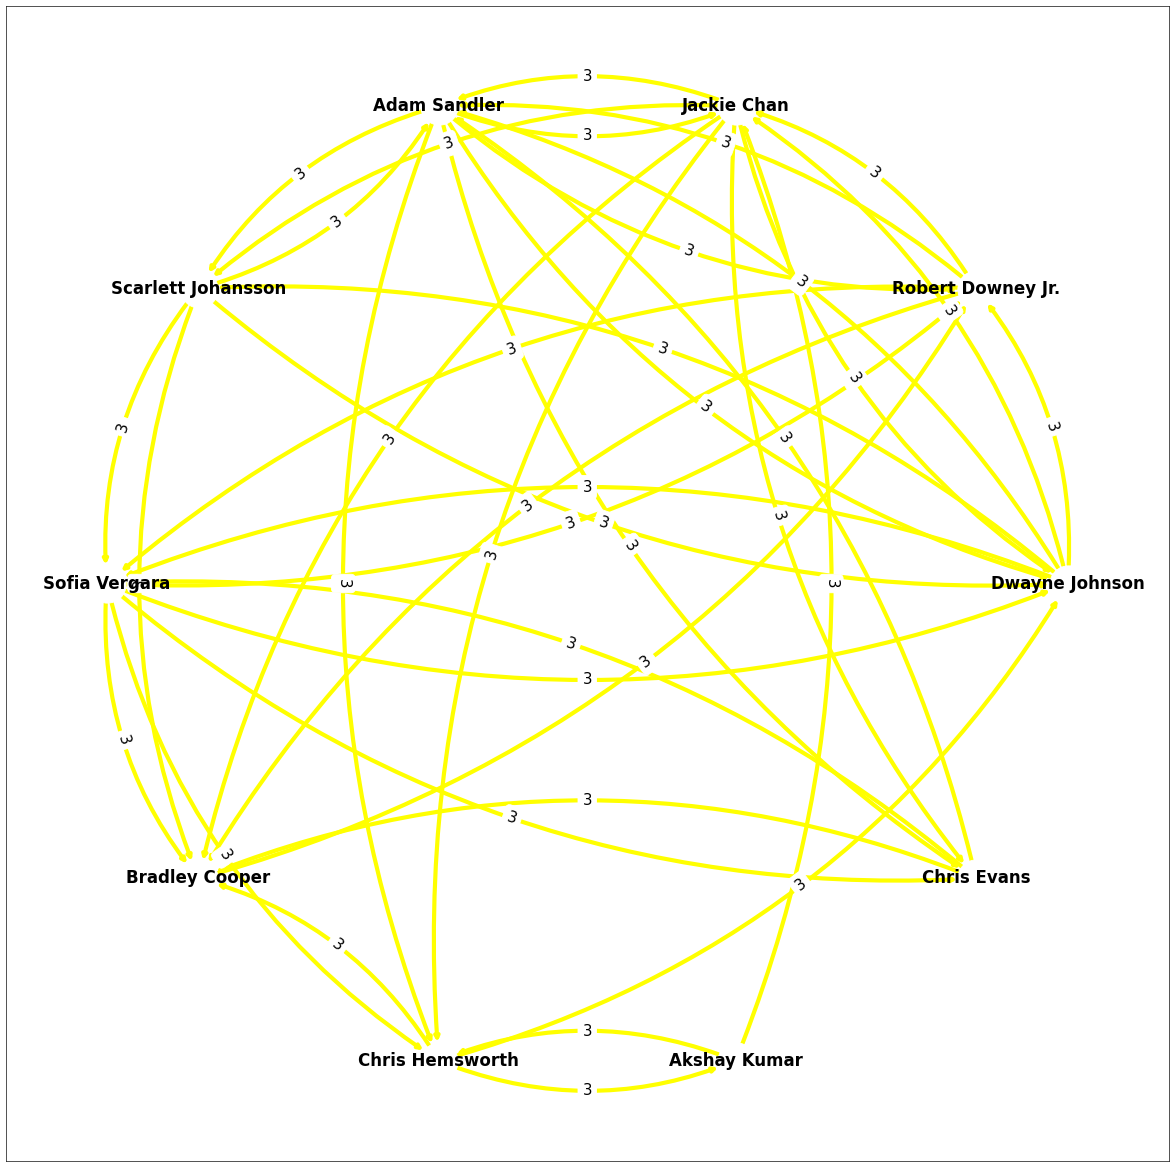

In [11]:
color = ['purple','blue', 'green', 'yellow', 'red', ]
for d in dist_values:
    graph = nx.DiGraph()
    for actor1 in actor_distances:
        for actor2 in actor_distances:
            w = actor_distances[actor1][actor2]
            if w == d:
                graph.add_edge(actor1, actor2, weight=w)
    plt.figure(figsize=(25, 25), dpi=60)
    pos = nx.layout.circular_layout(graph)

    edge_weights = nx.get_edge_attributes(graph, "weight")
    edges, lengths = zip(*edge_weights.items())
    nx.draw_networkx(graph, pos, node_color="white", edgelist=edges, node_size=2000,
                 edge_color=color[d], width=5, font_size=20, font_weight='bold',
                 connectionstyle='arc3,rad=0.2',arrows=True)

    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_weights, 
                             font_size=18,
                             connectionstyle='arc3,rad=0.2')
    plt.show()


## Undirected Graph

We can improve and simplify graph if we set distances between actors equal to minimum of $d(A, B)$ and $d(B, A)$ in both directions (from A to B and from B to A)

$d(A, B) = d(B, A) = min\{d(A, B); d(B, A)\}$

In [12]:
for actor1 in actor_distances:
    for actor2 in actor_distances:        
        d1 = actor_distances[actor1].get(actor2, -1)
        d2 = actor_distances[actor2].get(actor1, -1)
        if d1 > 0 and d2 > 0:
            d = min(d1, d2)
        else:
            d = max(d1, d2)
        actor_distances[actor1][actor2] = d
        actor_distances[actor2][actor1] = d

In [13]:
symmetrical_dist_df = pd.DataFrame(actor_distances).fillna(-1).astype(int)
symmetrical_dist_df.to_csv('symmetrical_distances.csv')
symmetrical_dist_df

Dwayne Johnson  Robert Downey Jr.  Chris Hemsworth  \
Dwayne Johnson                   0                  2                2   
Robert Downey Jr.                2                  0                1   
Chris Hemsworth                  2                  1                0   
Akshay Kumar                    -1                 -1                3   
Jackie Chan                      3                  3                2   
Bradley Cooper                   2                  3                2   
Adam Sandler                     3                  3                3   
Scarlett Johansson               3                  1                2   
Sofia Vergara                    3                  3                3   
Chris Evans                      2                  1                2   

                    Akshay Kumar  Jackie Chan  Bradley Cooper  Adam Sandler  \
Dwayne Johnson                -1            3               2             3   
Robert Downey Jr.             -1            3               3             3   
Chris Hemsworth                3            2               2             3   
Akshay Kumar                   0            3              -1            -1   
Jackie Chan                    3            0               3             3   
Bradley Cooper                -1            3               0             2   
Adam Sandler                  -1            3               2             0   
Scarlett Johansson            -1            3               2             3   
Sofia Vergara                 -1           -1               2             2   
Chris Evans                   -1            3               2             3   

                    Scarlett Johansson  Sofia Vergara  Chris Evans  
Dwayne Johnson                       3              3            2  
Robert Downey Jr.                    1              3            1  
Chris Hemsworth                      2              3            2  
Akshay Kumar                        -1             -1           -1  
Jackie Chan                          3             -1            3  
Bradley Cooper                       2              2            2  
Adam Sandler                         3              2            3  
Scarlett Johansson                   0              2            2  
Sofia Vergara                        2              0            3  
Chris Evans                          2              3            0

In [14]:
G = nx.Graph()
for actor1 in actor_distances:
    for actor2 in actor_distances:  
        d = actor_distances[actor1][actor2]
        if d > 0:
            G.add_edge(actor1, actor2, weight=d)

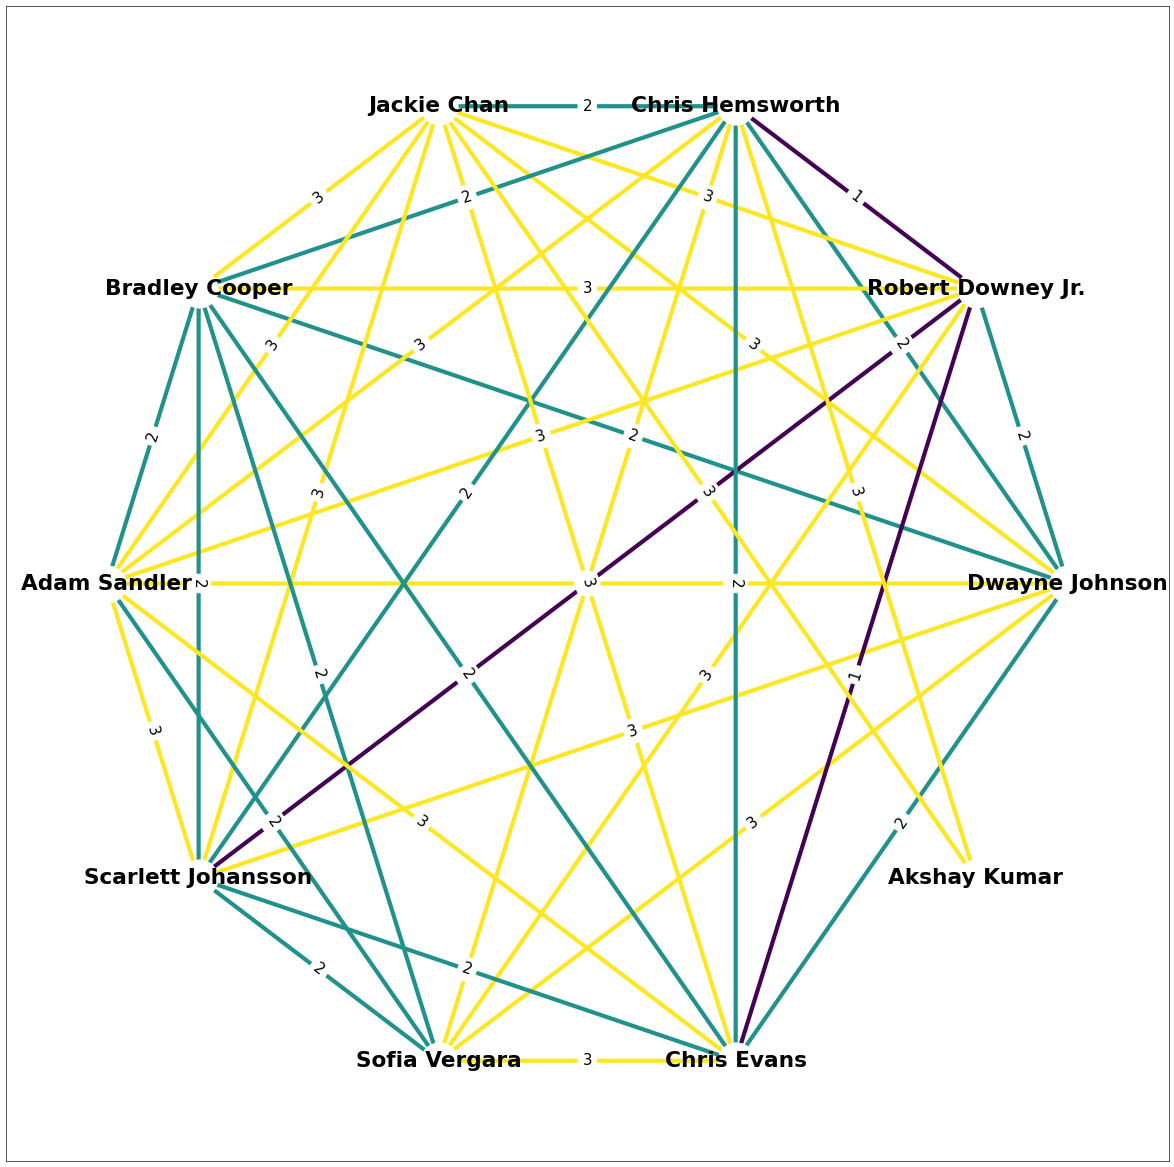

In [15]:
fig = plt.figure(figsize=(25, 25), dpi=60)
pos = nx.layout.circular_layout(G)

edge_weights = nx.get_edge_attributes(G, "weight")
edges, lengths = zip(*nx.get_edge_attributes(G, "weight").items())

nx.draw_networkx(G, pos, node_color="white", edgelist=edges, node_size=2000,
                 edge_color=lengths, width=5, font_size=26, font_weight='bold',
                arrows=True)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, 
                             font_size=18,)
plt.show()

### Graphs by distances

Distance: 1


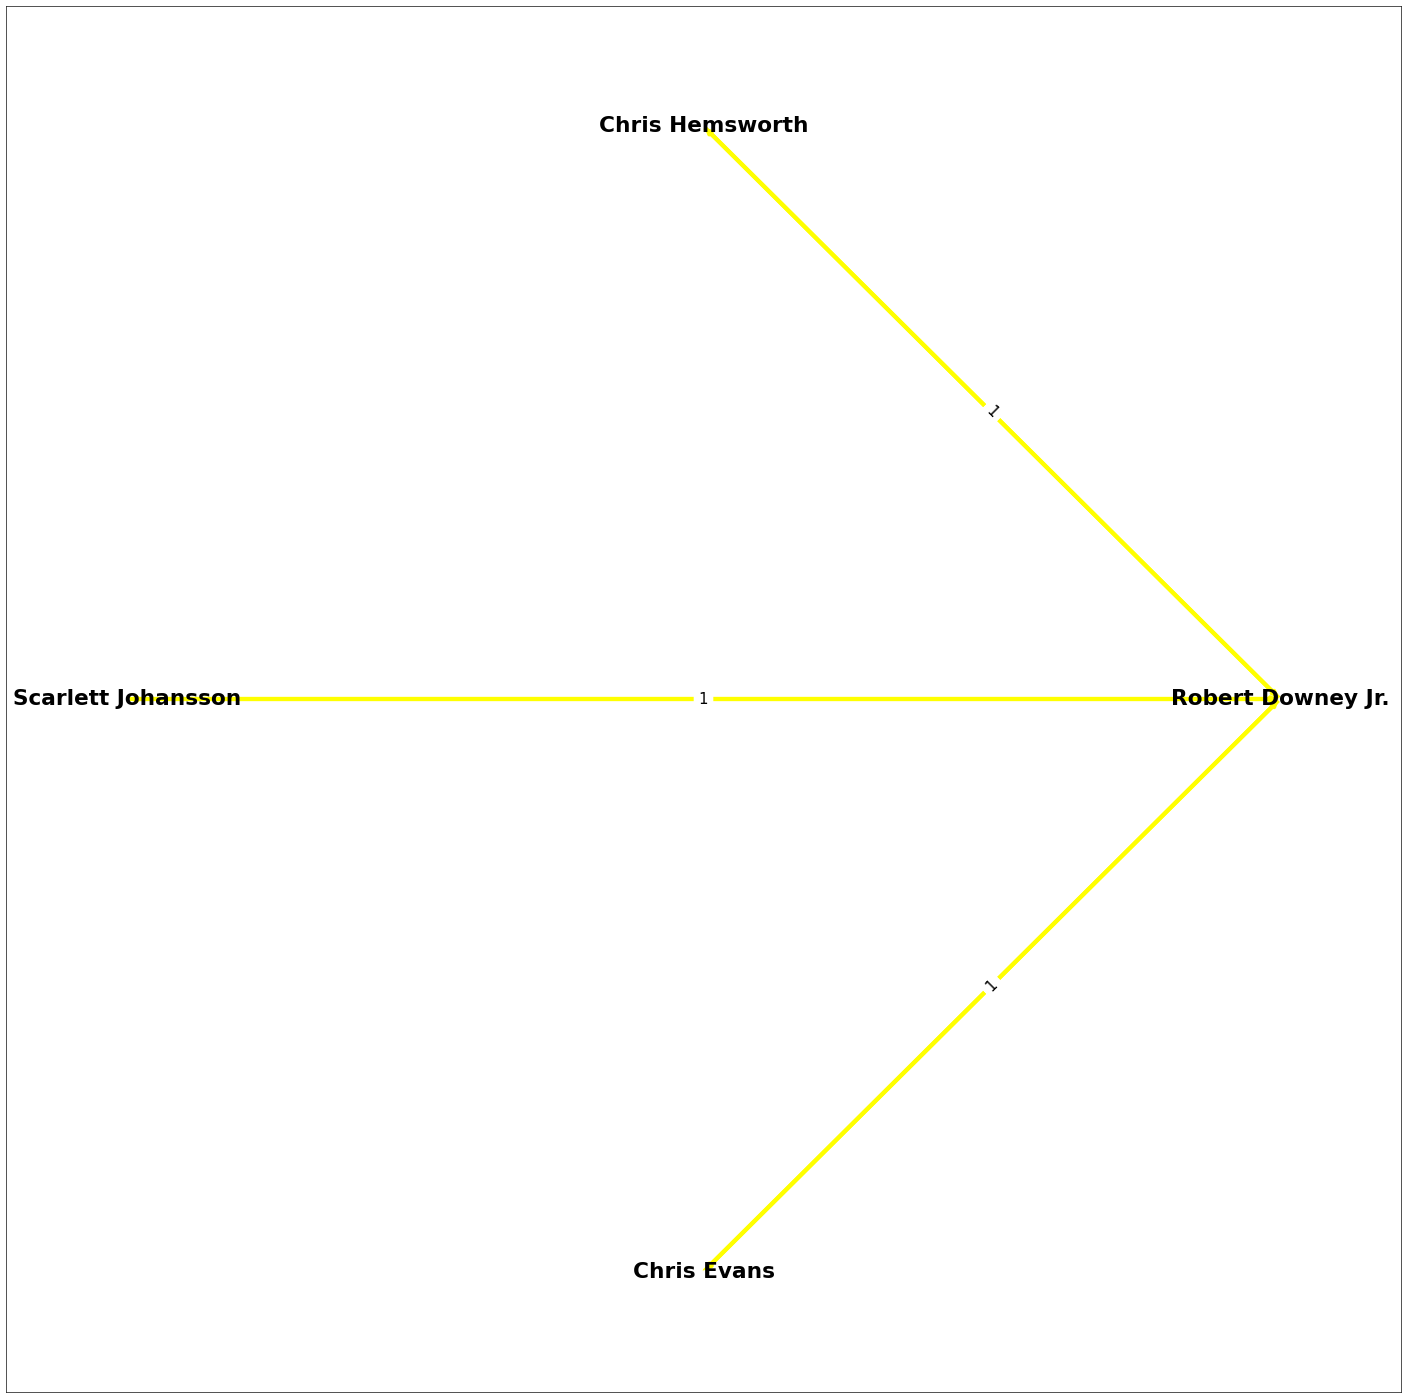

Distance: 2


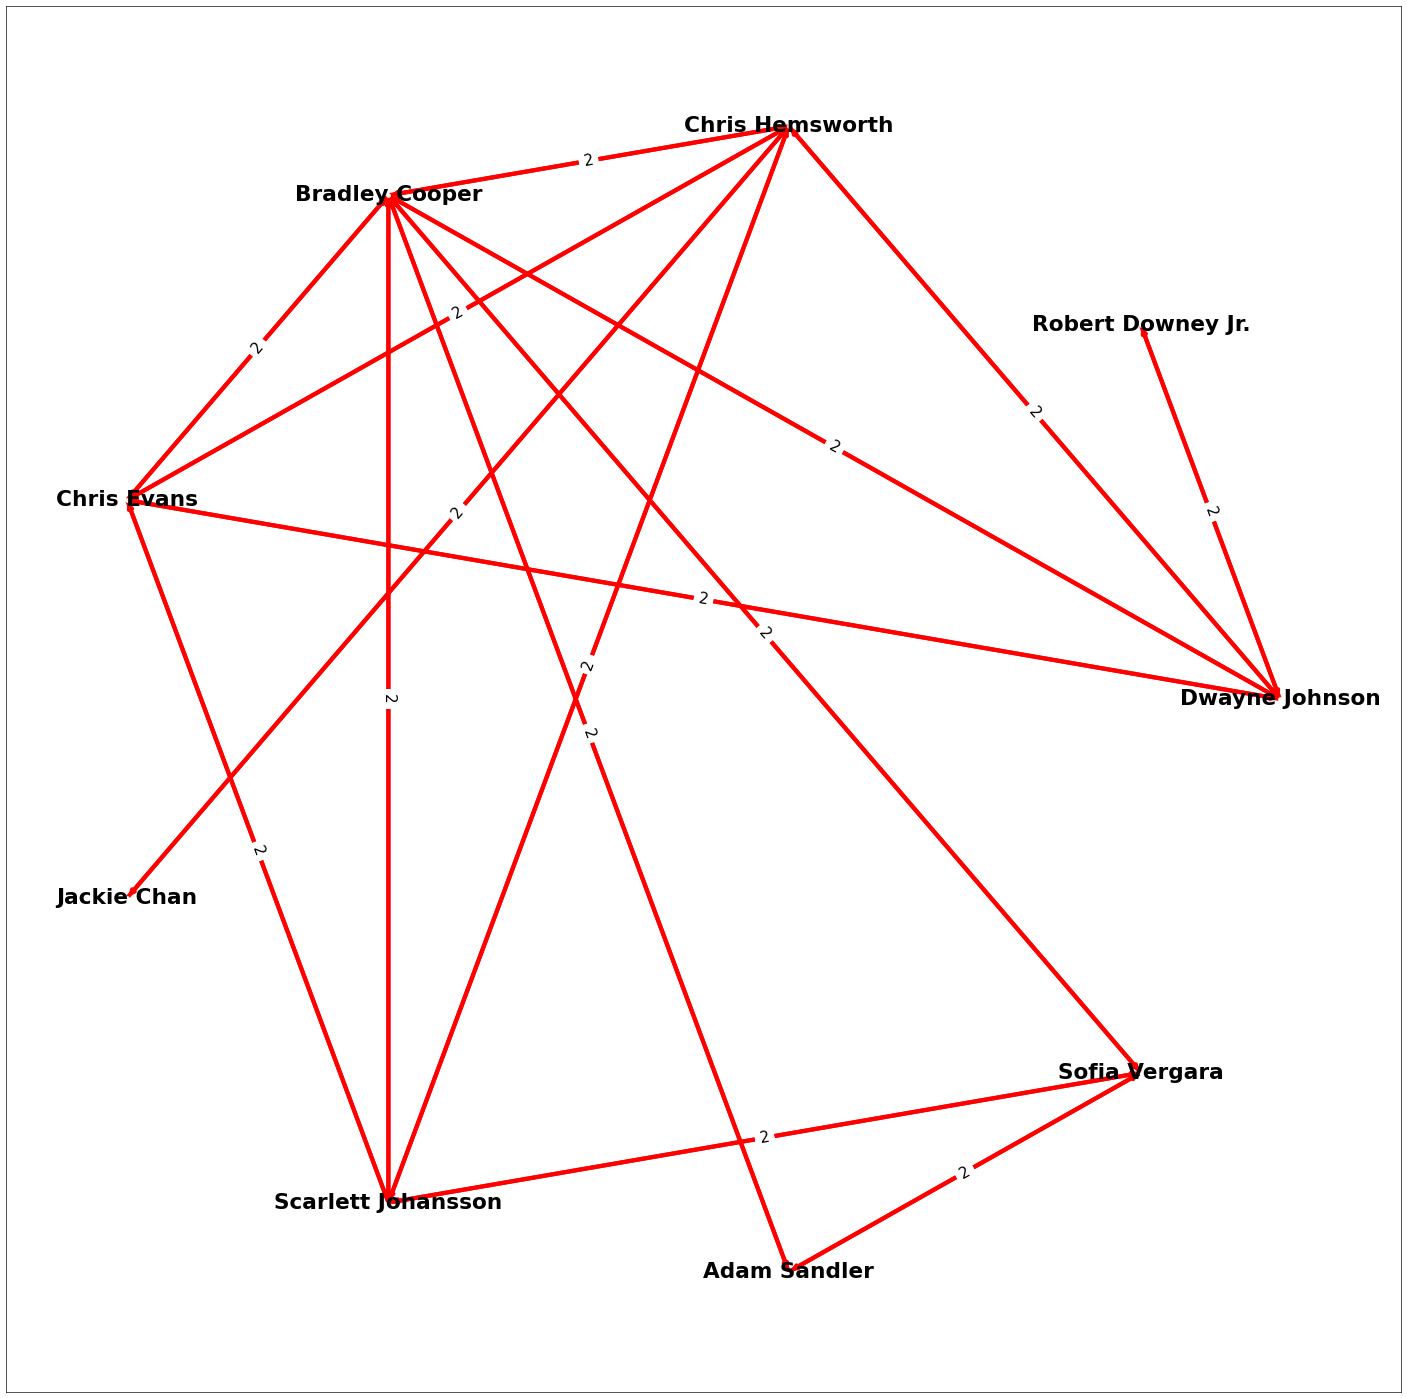

Distance: 3


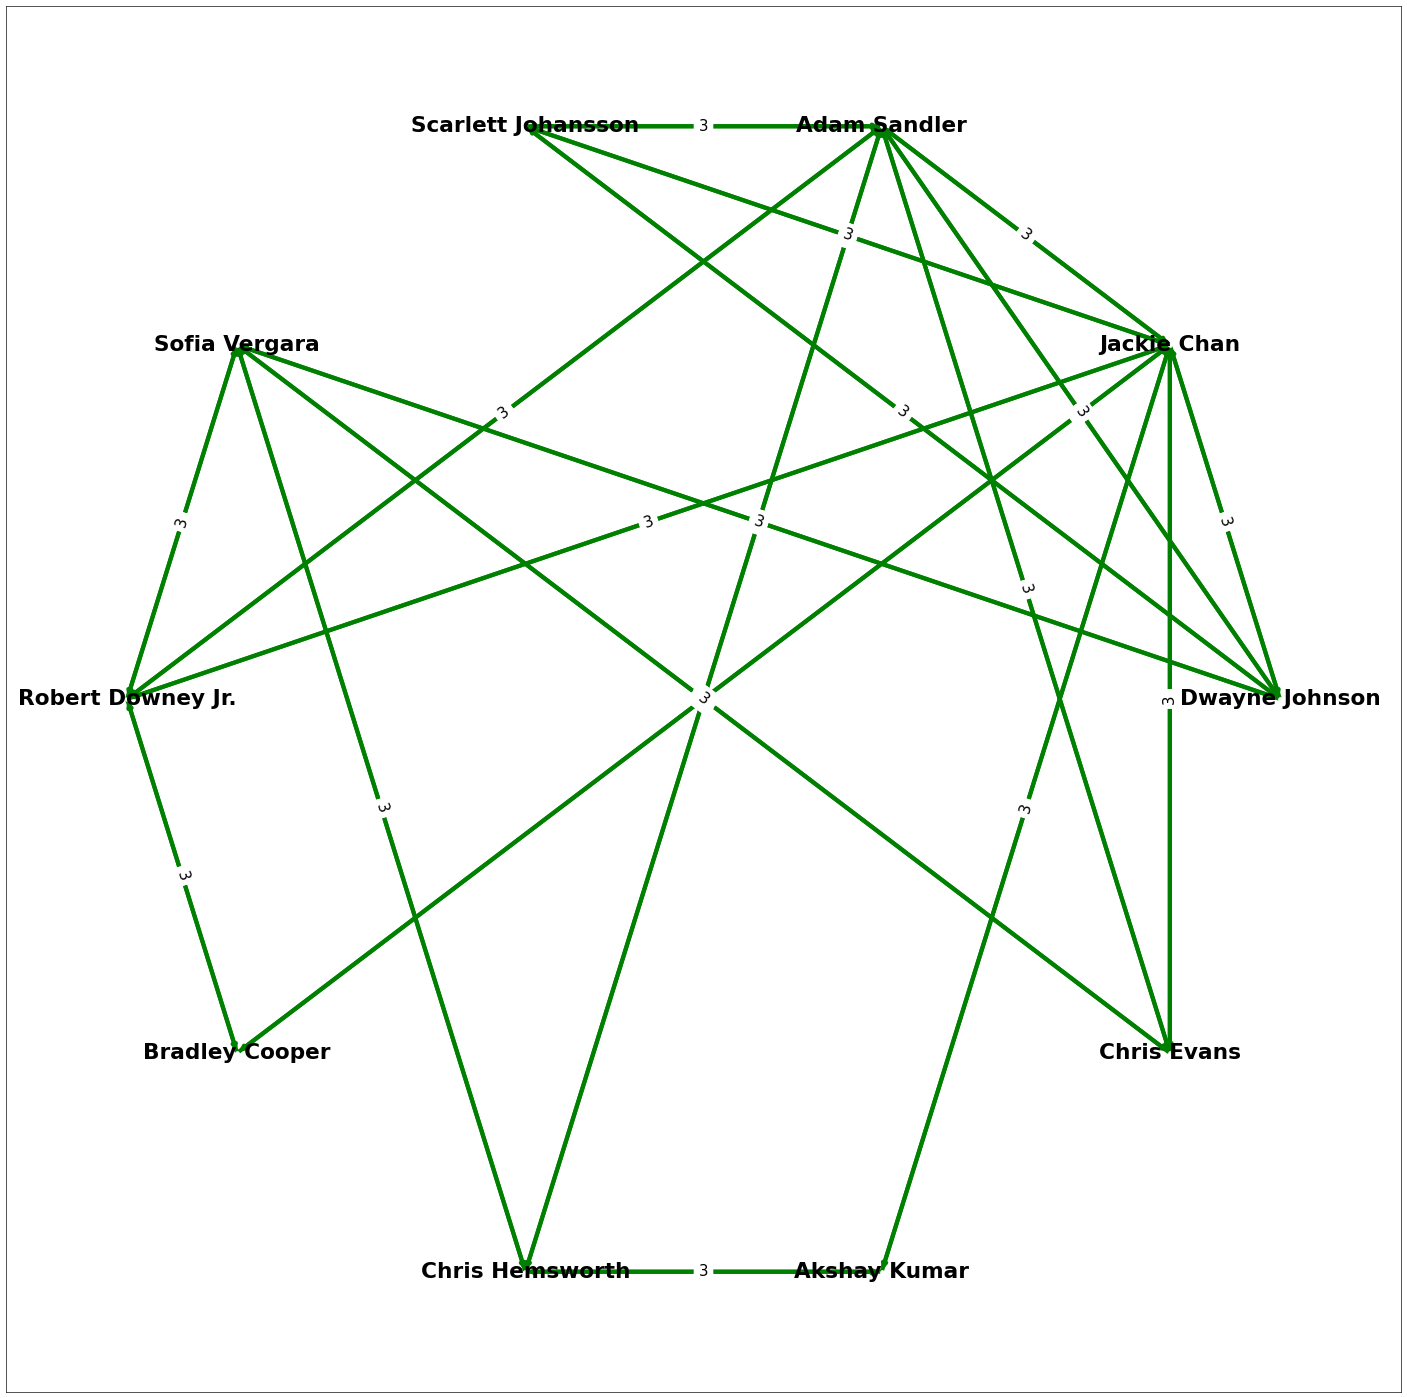

In [16]:
color = ['blue', 'yellow','red', 'green', ]
for d in dist_values:
    print(f'Distance: {d}')
    G = nx.DiGraph()
    for actor1 in actor_distances:
        for actor2 in actor_distances:
            w = actor_distances[actor1][actor2]
            if w == d:
                G.add_edge(actor1, actor2, weight=w)
    plt.figure(figsize=(30, 30), dpi=60)
    pos = nx.layout.circular_layout(G)

    edge_weights = nx.get_edge_attributes(G, "weight")
    edges, lengths = zip(*edge_weights.items())
    nx.draw_networkx(G, pos, node_color="white", edgelist=edges, node_size=20,
                 edge_color=color[d], width=5, font_size=26, font_weight='bold')

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, 
                             font_size=18)
    plt.show()

# Wordcloud

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
%matplotlib inline

### Get descriptions and save to files

or load from files in the next cells

In [25]:
# Run to parse web pages or load from files in the next cell
descriptions = {}
for actor in url_by_actor:
    print(f'Collecting descriptions of movies by {actor}')
    descr = imdb.get_movie_descriptions_by_actor_url(url_by_actor[actor])
    descriptions[actor] = descr

    with open(f'descriptions/{actor}.txt', 'w', encoding='utf8') as f:
        for text in descr:
            f.write(text)
            f.write('\n')

number of movies: 46
1/46: Fast X
2/46: Black Adam
3/46: DC League of Super-Pets
4/46: Red Notice
5/46: Free Guy
6/46: Jungle Cruise
7/46: Jumanji: The Next Level
8/46: Fast & Furious Presents: Hobbs & Shaw
9/46: Fighting with My Family
10/46: Skyscraper
11/46: Rampage
12/46: Jumanji: Welcome to the Jungle
13/46: Baywatch
14/46: The Fate of the Furious
15/46: Moana
16/46: Central Intelligence
17/46: Jem and the Holograms
18/46: San Andreas
19/46: Furious 7
20/46: Hercules
21/46: Fast & Furious 6
22/46: Pain & Gain
23/46: Empire State
24/46: G.I. Joe: Retaliation
25/46: Snitch
26/46: Journey 2: The Mysterious Island
27/46: Fast Five
28/46: Faster
29/46: You Again
30/46: The Other Guys
31/46: Why Did I Get Married Too?
32/46: Tooth Fairy
33/46: Planet 51
34/46: Race to Witch Mountain
35/46: Get Smart
36/46: The Game Plan
37/46: Reno 911!: Miami
38/46: Gridiron Gang
39/46: Southland Tales
40/46: Doom
41/46: Be Cool
42/46: Walking Tall
43/46: The Rundown
44/46: The Scorpion King
45/46: Lon

### Load from files

In [18]:
descriptions = {}
for actor in url_by_actor:
    with open(f'descriptions/{actor}.txt', 'r', encoding='utf8') as f:
        descriptions[actor] = f.readlines()

### Preprocessing descriptions. Removing stopwords from descriptions

In [19]:
for actor in descriptions:
    stopwords = set(STOPWORDS)
    stopwords.update([*'abcdefghijklmnopqrstuvwxyz'])
    stopwords.update(["now", "gets", "sets", 
                    'must', 'one', 'two', 
                    'set', 'get', 'new',
                    'young', 'tries', 'make'
                    'becomes', 'year', 'stop',
                    'take', 'find', 'back',
                    'man', 'woman', 'boy', 
                    'girl', 'become'])
    
    descriptions[actor] = ' '.join(t for t in descriptions[actor])   

    descr = re.split(re.compile('[!?.,\(\): \\n\"]'), descriptions[actor].lower())
    for word in stopwords:
        while word in descr:
            descr.remove(word)
    
    descr = ' '.join(t.lower().strip() for t in descr)
    descriptions[actor] = descr

### Generating wordclouds images

Wordcloud for Dwayne Johnson


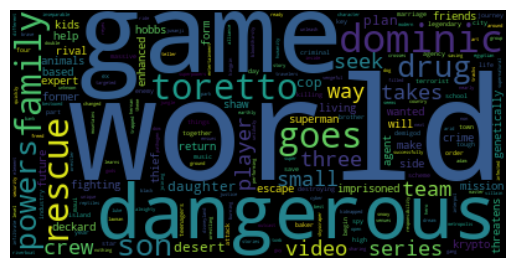

Wordcloud for Robert Downey Jr.


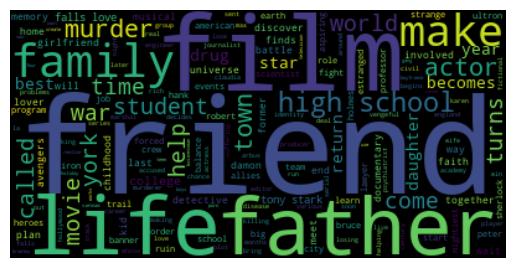

Wordcloud for Chris Hemsworth


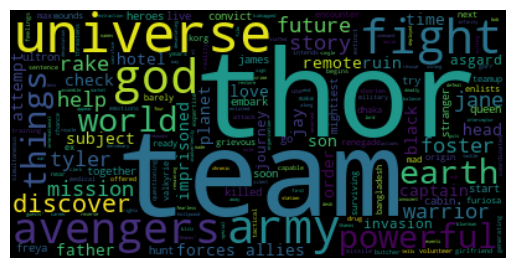

Wordcloud for Akshay Kumar


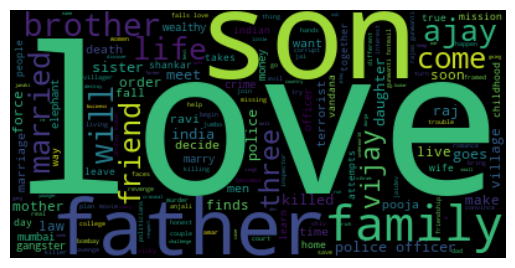

Wordcloud for Jackie Chan


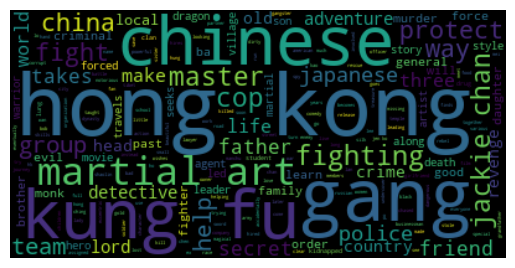

Wordcloud for Bradley Cooper


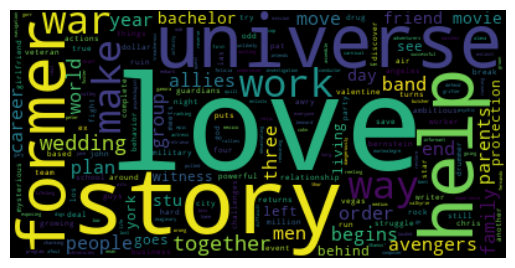

Wordcloud for Adam Sandler


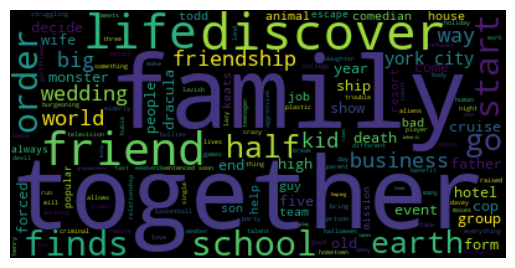

Wordcloud for Scarlett Johansson


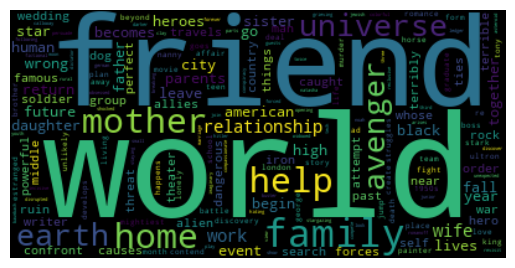

Wordcloud for Sofia Vergara


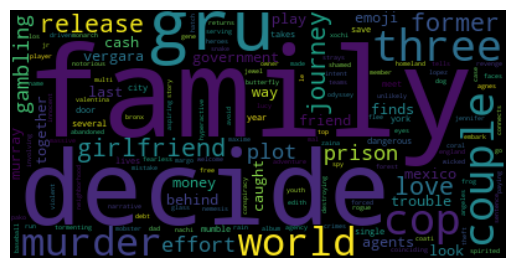

Wordcloud for Chris Evans


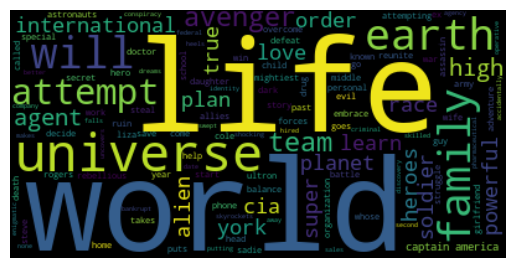

In [20]:
# Create and generate a word cloud image:
for actor in descriptions:
    wordcloud = WordCloud().generate(descriptions[actor])

    # Display the generated image:
    print(f'Wordcloud for {actor}')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
                  